# Premise

**Background**

---
The stock market is a platform through with securities (also referred to as shares, stocks, equity, etc.) are traded daily. When an individual or corporation buys a share of a stock, they are purchasing a fraction of ownership of the publicly traded company the stock belongs to. 

The price of a single share changes throughout the business hours of the stock exchange it is traded on, normally 9 am to 5 pm, Monday to Friday in the United States. During these hours, the market is *open*, and securities can be bought and sold freely. When the market closes, no securities can be traded. The price of a share can fluctuate between the close of the market and the next time it opens; often, news or earnings reports about a company can have a major impact on the value of a stock, and take place after market hours. Investors are unable to trade shares of any company until the market opens, by which the opening share price will already reflect the new information revealed since the previous day's close. Some institutions are given the ability to trade pre- and post-hours, but not the typical investor.

There are many economic metrics used to measure the value of a security. There are *momentum* indicators, which measure if the price of a share is rising, falling, how quickly, and for how long. There are *value* metrics, which compare the *actual* price of a security with a mathematical calculation of what the price *should* be. This calculation varies for every analyst, though some common metrics take into account a companiy's revenue, profit, cash flow, liabilities, etc.

**Goal**

---

The goal of this project is to create an algorithm that increases the profit realized by investors. 



**Methods**

---

This goal will be acheived by using two models, a *Logistic Regression* and *Neural Network*.

The data was scraped from the internet for individual stocks. This includes daily price and trading data, as well as earnings data for every quarter since 1995.

The scraped data was manipulated to calculate a variety of value- and momentum-based metrics.

For each trial, a testing date is given. The training data includes a 1 or 2 year period (chosen as a hyperparamter of the model) occurring at least *n* days before the testing date. The test data is comprised of the 6 month period following the testing date.

*N* corresponds the the classifcation of an instance. This data has a binary classification defined by whether or not the price of the security increased *n* business days after the current date. It is for this reason that there must be a gap of *n* days between the training and test data. This value is also selected as a hyperparameter of the model. Predicting the price of a stock 1 day into the future (which would practically yield the highest returns), is nearly impossible. It is unrealistic to do so given the feature spaced used in this project, as no geopolitical or media information was gleaned.

*Note: This model does not take dividend payouts into account, and all stock prices are split-adjusted.

**Performance**

---

Economic climates can vary by month, quarter, and year. To gain a more accurate understanding of a model's performance, every 6 month period was tested from the period beginning on January 1st, 2003 to the period beginning on January 1st, 2016 (which ends on July 1st, 2016). The total returns of the model are then aggregated and compared with the total returns of the *unengaged investor*.

The *unengaged investor* is a control group to compare the model against. Many analysts try to predict the market, and end up making less money than they would have if they didn't do anything. The *unengaged investor* mimics the returns that would be realized if a stock was bought on the first day of a period and kept untili the final day of the period (also referred to at the *static return*). The model buys and sells a security each day depending on the predicted classification of the test data. 

When an instance is classified as True (meaning the model expects the share price to increase in the future), the model buys a share of the stock. It then holds the stock until it classifies an instance as False (meaning the model expects the share price to decrease in the future). The maximum returns would be realized if the model were to buy a security the day before it increases, and sell it the day before it decreases, for every day in the test period. The inverse is also possible, which would be the worst case.

The performance of this model will not be measured by the accuracy of its predictions. Rather, the most practical measurement of this model are to compare its returns to the *unengaged investor*. If the model produces higher returns than an investor who did not use the model and merely held a security for the duration of the period, than utilizing the model to guide investment decisions will have been worthwhile.

*Note: Other measures of success could have also been selected. For example, one could have optimized the model to reduce volatility or minimize losses. This project, however, optimizes the model by maximizing returns without regard for volaility or short-term losses.*

# Import packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
from pandas_datareader import data as wb
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

# Define code for model

## Define code for pulling individual stock data

In [0]:
sectorInfo = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv').set_index('Symbol')

In [0]:
def getTickers(step):
    '''
    Input: integer
    Output: list (of ticker symbols)

    This function returns a list of ticker symbols. On www.stockpup.com, there are 500+ data sets.
    This function returns every step-th ticker symbol associated with the available datasets.
    '''
    url = 'http://www.stockpup.com/data/'
    site = BeautifulSoup(requests.get(url).text, "html.parser")
    files = site.findAll('a')[22:-1][::step]
    
    tickers = []
    for f in files:
        if f['href'][-3:] == 'csv':
            tickers.append(f['href'][6:].split('_')[0])
    return tickers

In [0]:
def getPriceData(ticker, daysIntoFuture):  
    '''
    Input: string (ticker sybol), integer (value used in determining the classification of an instance)
    Output: pandas dataframe (historical stock trading data)

    This function creates a dataframe containing the historical trading data for a given stock.
    All trading data from January 1st, 1995 is pulled from yahoo.
    Features calculated from this data include:
        - Ticker
        - 52 Week High
        - 52 Week Low
        - 10 Day Moving Average 
        - 50 Day Moving Average
        - 200 Day Moving Average
        - 1 Day Change
        - 5 Day Change
        - 30 Day Change
        - Class
    The class feature is determined by whethter or not the price of the stock increased
    n business days into the future, where n is given by the input variable daysIntoFuture.
    '''
    pData = pd.DataFrame()

    startDate = '1995-01-01'
    dataSource = 'yahoo'

    ticker_data= wb.DataReader(ticker, data_source = dataSource, start = startDate)
    pData = pd.DataFrame(ticker_data)[['Close', 'Volume']]
    pData['Ticker'] = ticker
    
    pData['52 Week High'] = pData['Close'].rolling(window = 5*52).max()
    pData['52 Week Low'] = pData['Close'].rolling(window = 5*52).min()

    pData['10 Day Moving Average'] = pData['Close'].rolling(window = 10).mean()
    pData['50 Day Moving Average'] = pData['Close'].rolling(window = 50).mean()
    pData['200 Day Moving Average'] = pData['Close'].rolling(window = 200).mean()

    pData['1 Day Change'] = (pData['Close'] - pData['Close'].shift(1)) / pData['Close'].shift(1)
    pData['5 Day Change'] = (pData['Close'] - pData['Close'].shift(5)) / pData['Close'].shift(5)
    pData['30 Day Change'] = (pData['Close'] - pData['Close'].shift(30)) / pData['Close'].shift(30)

    pData['Class'] = pData['Close'].rolling(daysIntoFuture).sum().shift(-daysIntoFuture) - pData['Close'].rolling(daysIntoFuture - 1).sum().shift(-daysIntoFuture + 1) > pData['Close']
    
    return pData.reset_index()

In [0]:
def pullStockData(tick, daysIntoFuture = 30):
    '''
    Inputs: string (ticker symbol), integer (value used in determining the classification of an instance)
    Output: pandas dataframe (historical stock trading and earnings data)

    This function creates a dataframe containing the historical trading and earnings data for a given stock.
    All trading data from January 1st, 1995 is pulled from yahoo and www.stockpup.com

    Features calculated from this data include:
      TRADING METRICS
        - Close (price at the close of the business day)
        - Price / 52 Week High
        - Price / 52 Week Low
        - 10 Day Moving Average Ratio
        - 50 Day Moving Average Ratio
        - 200 Day Moving Average Ratio
        - 1 Day Change
        - 5 Day Change
        - 30 Day Change
        
      FUNDAMENTALS/EARNINGS METRICS
        - Market / Book Ratio
        - P/E (price to earnings ratio)
        - Debt / Equity Ratio
        - Free Cash Flow Yield
    
    The class feature is determined by whethter or not the price of the stock increased
    n business days into the future, where n is given by the input variable daysIntoFuture.
    '''
   
    url = 'http://www.stockpup.com/data/'
    filePath = '_quarterly_financial_data.csv'

    fData = pd.read_csv(url + tick + filePath)
    
    # Get fundamentals data for stock
    fData = fData[['Quarter end',
                    'Cash at end of period',
                    'Shares split adjusted',
                    'Cash from operating activities',
                    'Capital expenditures',
                    'Assets',
                    'Liabilities',
                    'EPS basic']]
    fData['Ticker'] = tick
    
    fData['Cash from operating activities'] = pd.to_numeric(fData['Cash from operating activities'], errors = 'coerce')
    fData['EPS basic'] = pd.to_numeric(fData['EPS basic'], errors = 'coerce')
    fData['Quarter end'] = pd.to_datetime(fData['Quarter end'])
    fData = fData.reset_index().drop(columns = ['index']).sort_values(by = 'Quarter end', ascending = True)

    # Get price data for stock
    pData = getPriceData(tick, daysIntoFuture)

    # Merge price and fundamentals data and build attributes
    stockData = pd.merge_asof(pData, fData, left_on = 'Date', right_on = 'Quarter end', by = 'Ticker', direction = 'backward', allow_exact_matches = False)
    try:
        stockData['Sector'] = sectorInfo['Sector'][tick]
    except:
        stockData['Sector'] = 'Unknown'

    stockData['Market / Book Ratio'] = stockData['Close'] / (stockData['Assets'] - stockData['Liabilities']) * stockData['Shares split adjusted']
    stockData['P/E'] = stockData['Close'] / stockData['EPS basic']
    stockData['Debt / Equity Ratio'] = stockData['Liabilities'] / (stockData['Assets'] - stockData['Liabilities'])
    stockData['Free Cash Flow Yield'] = (stockData['Cash from operating activities'] - stockData['Capital expenditures']) / (stockData['Shares split adjusted']*stockData['Close'] + stockData['Liabilities'] - stockData['Cash at end of period'])
    
    stockData['Price / 52 Week High'] = stockData['Close'] / stockData['52 Week High']
    stockData['Price / 52 Week Low'] = stockData['Close'] / stockData['52 Week Low']
    
    stockData['10 Day Moving Average Ratio'] = stockData['Close'] / stockData['10 Day Moving Average']
    stockData['50 Day Moving Average Ratio'] = stockData['Close'] / stockData['50 Day Moving Average']
    stockData['200 Day Moving Average Ratio'] = stockData['Close'] / stockData['200 Day Moving Average']
    
    stockData = stockData[['Ticker',
                            'Sector',
                            'Date',
                            'Close',
                            'Price / 52 Week High', 
                            'Price / 52 Week Low', 
                            '10 Day Moving Average Ratio',
                            '50 Day Moving Average Ratio',
                            '200 Day Moving Average Ratio',
                            '1 Day Change',
                            '5 Day Change',
                            '30 Day Change',
                            'Volume',
                            'Market / Book Ratio',
                            'P/E',
                            'Debt / Equity Ratio',
                            'Free Cash Flow Yield',
                            'Class']]

    return stockData .dropna()

In [0]:
allFeatures = ['Price / 52 Week High', 'Price / 52 Week Low', 
               '10 Day Moving Average Ratio', '50 Day Moving Average Ratio',
               '200 Day Moving Average Ratio', 'Volume',
               'Market / Book Ratio', 'P/E', 'Debt / Equity Ratio',
               'Free Cash Flow Yield']

## Code for the Logistic Regression

In [0]:
class LogisticRegression():
    
    def __init__(self, learningRate = 0.01, numIter = 5000, thresh = 0.5, fitIntercept = True, printUpdates = True):
        self.learningRate = learningRate
        self.numIter = numIter
        self.thresh = thresh
        self.fitIntercept = fitIntercept
        self.printUpdates = printUpdates
        self.errors = []
        self.average = .5

    def addIntercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis = 1)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, Y, h):
        return (-Y * np.log(h) - (1 - Y)*np.log(1 - h)).mean()

    def fit(self, X, Y):
      '''
      Inputs: pandas dataframe (training instances), series (training classifications)
      Outputs: None

      This function takes in the training data and fits a logistic regression to it.
      '''
      self.trainingData = (X, Y)
      if self.fitIntercept:
          X = self.addIntercept(X)
      
      # Initialize weights
      self.theta = np.zeros(X.shape[1])

      for i in range(1, self.numIter + 1):
          z = np.dot(X, self.theta)
          h = self.sigmoid(z)
          gradient = np.dot(X.T, (h - Y)) / Y.size
          self.theta -= self.learningRate * gradient
          self.errors.append(self.loss(Y, h))

          if (i % 100 == 0 and self.printUpdates):
                print('Iteration %d  Error: %.4f' % (i, self.errors[-1]))
      #self.threshold = sum(Y) / len(Y)
          
    def predictProb(self, X):
        '''
        Inputs: pandas dataframe (testing instances)
        Output: array (of floats)

        This function takes in a testing dataset (without classifications) and uses the trained
        model to predict the probabilities associated with each instance. The returned
        floats correspond to the probabilities that each instance is classified as True.
        '''
        if X.shape[1] < self.theta.shape[0]:
            X = self.addIntercept(X)
        
        return self.sigmoid(np.dot(X, self.theta))

    def predict(self, X):
        '''
        Inputs: pandas dataframe (testing instances)
        Output: array (of binary classifications)

        This function takes in a testing dataset (without classifications) and uses the trained
        model to predict the probabilities associated with each instance. The returned
        binary values correspond to the binary classifications predicted by the model.
        '''
        return self.predictProb(X) > self.thresh

    def printThresholds(self, cols):
        print('These are the weights for each column for this model:')
        print('%30.30s:   %.2f' % ('Intercept', self.theta[0]))
        for i in range(1, len(self.theta)):
            print('%30.30s:   %.2f' % (cols[i -1], self.theta[i]))

## Code for the Neural Network

In [0]:
class ANN:
    
    def __init__(self, size, momentum = 0.0, nIters = 1000, lr = 0.25, thresh = 0.01, printUpdates = True):
        """ 
        ---
        Network constructor for multi-class classification
        ---
        size: network size as an array of number of units in input, hidden, output layers
              i.e. [100,300,10,5] indicates 100 neurons in input layer, 300 and 10 neurons in subsequent 
              hidden layes and 5 neurons in output layer
        momentum: a constant, to avoid local minima
        nIters: number of iterations
        lr: learning rate
        
        """
        self.size = size
        self.nHidden = len(self.size) - 2 #except input and output layer
        self.momentum = momentum
        self.lr = lr
        self.thresh = thresh
        self.nIters = nIters
        self.errors = []
        self.printUpdates = printUpdates
        
        self.weights = {}
        self.biases = {}
        # Initialize weights and biases
        for k in range(self.nHidden + 1):
            self.weights[k+1] = np.random.randn(self.size[k], self.size[k+1]) / np.sqrt(self.size[k])
            self.biases[k+1] = np.random.rand(1,self.size[k+1])
        
        
    def feedFwd(self, inputs):
        """ Propagate the network forward """
        if type(inputs) != np.ndarray:
            inputs = inputs.to_numpy()
        self.pre_activations = {} #Linear, i.e. w.x+b
        self.hidden = {} # after activation, i.e. sigmoid(w.x+b)
        
        self.hidden[0] = np.array([inputs])
        for k in range(self.nHidden + 1):
            self.pre_activations[k+1] = np.dot(self.hidden[k], self.weights[k+1]) + self.biases[k+1] 
            self.hidden[k+1] = sigmoid(self.pre_activations[k+1])
        
        output = self.hidden[self.nHidden + 1]
        return output
    
    def backProp(self, inputs, targets):
        #self.feedFwd(inputs)
        
        self.d_weights = {}
        self.d_biases = {}    
        self.d_hidden = {}
        
        for k in range(self.nHidden + 1):
            self.d_weights[k+1] = np.zeros((np.shape(self.weights[k+1])))
            self.d_biases[k+1] = np.zeros((np.shape(self.biases[k+1])))
            
        self.output = self.feedFwd(inputs)
        #error = (1/2)*np.sum((self.output - targets)**2)
        
        self.d_hidden[self.nHidden + 1] = (targets - self.output)*grad_sigmoid(self.output) # delta_o
        
        # compute deltas
        for k in range(self.nHidden + 1, 0, -1):
            self.d_hidden[k-1] = grad_sigmoid(self.hidden[k-1])*(np.dot(self.d_hidden[k],np.transpose(self.weights[k])))
            self.d_weights[k] = np.transpose(np.dot(np.transpose(self.d_hidden[k]),self.hidden[k-1])) + self.momentum*self.d_weights[k]
            self.d_biases[k] = self.d_hidden[k] + self.momentum*self.d_biases[k] 
            
    def train(self, X, Y):
        '''
        Inputs: pandas dataframe (training instances), series (training classifications)
        Outputs: None

        This function takes in the training data and fits a logistic regression to it.
        '''
        X = X.to_numpy()
        Y = Y.to_numpy()
        pred = np.empty(Y.shape)
        for i in range(self.nIters+1):
            for k, (x, y) in enumerate(zip(X,Y)):
                self.backProp(x,y)
                pred[k] = self.feedFwd(x)

                # weight updates
                for k in range(self.nHidden + 1):
                    self.weights[k+1] += self.lr*self.d_weights[k+1]
                    self.biases[k+1] += self.lr*self.d_biases[k+1]
                
            self.errors.append(np.sum(pred-Y))
            if (i % 10 == 0 and self.printUpdates):
                print('Iteration %d  Error: %.4f' % (i, self.errors[-1]))
            if len(self.errors) > 1:
                if abs(self.errors[-1] - self.errors[-2]) < self.thresh:
                    break

    def predictProb(self, X):
        '''
        Inputs: pandas dataframe (testing instances)
        Output: array (of floats)

        This function takes in a testing dataset (without classifications) and uses the trained
        model to predict the probabilities associated with each instance. The returned
        floats correspond to the probabilities that each instance is classified as True.
        '''
        return self.feedFwd(X)[0,:,0]

    def predict(self, X):
        '''
        Inputs: pandas dataframe (testing instances)
        Output: array (of binary classifications)

        This function takes in a testing dataset (without classifications) and uses the trained
        model to predict the probabilities associated with each instance. The returned
        binary values correspond to the binary classifications predicted by the model.
        '''
        return self.predictProb(X) > .5

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def grad_sigmoid(z):
    return z*(1 - z) 

## Code for running the model

In [0]:
startMidDate = '01-01-2003'
finalMidDate = '01-01-2016'

def normalize(X): 
    ''' 
    Input: Matrix or dataframe (containing only floats)
    Output: Matrix or dataframe

    This function normalizes the input matrix or dataframe along each column and across all rows.
    '''
    mins = np.min(X, axis = 0) 
    maxs = np.max(X, axis = 0) 
    rng = maxs - mins 
    norm_X = 1 - ((maxs - X)/rng) 
    return norm_X 

def runModel(ticker, midDate, trainDataYears = 2, modelType = 'LogReg', daysIntoFuture = 30, lr = 0.01, numIter = 5000, updates = True, printResults = True, cols = allFeatures, thresh = 0.5):
    '''
    Inputs: string (ticker symbol), string (midDate, of format 'mm-dd-yyyy'), **kwargs
    **kwargs:
        - trainDataYears: int
            This int corresponds to the length of the training data, in years
        - modelType: string, {'LogReg', 'NeuralNet'}
            This defines whether the model is a logistic regression or a neural network
        - daysIntoFuture: int, used to define the classification of each instance
        - lr: float, learning rate of the model
        - numIter: int, number of iterations used in fitting the model
        - updates: Boolean
            If True, updates about the model's progress will be printed when fitting it to the training data
        - printResults: Boolen
            If True, the results (accuracy, returns) of the model will be printed after testing the model
        - cols: list of strings, where each element is a feature that is to be included in the returned dataframes
        - thresh: float, the cutoff between predicting True and False when predicting classifications
    Output: pandas dataframe (trainData), pandas dataframe (testData)

    This function creates a model for a specific stock over a given training period and tests it over a 6 month period.
    '''
    np.random.seed(0)
    data = pullStockData(ticker, daysIntoFuture)
    
    startTrainData = subtractNDays(midDate, daysIntoFuture - 1)
    for i in range(trainDataYears):
        startTrainData = subtractOneYear(startTrainData)

    # Get training and test data
    trainData, testData = getTrainTest(data, midDate, startDate = startTrainData, cols = cols, daysIntoFuture = daysIntoFuture)  

    # Create inputs and outputs for the training data
    X = trainData[cols]
    Y = trainData['Class']
    pricesTrain = trainData['Close']

    # Create inputs and outputs for the test data
    xTest = testData[cols]
    yTest = testData['Class']
    pricesTest = testData['Close']

    if modelType == 'LogReg':
        # Create and fit the model
        model = LogisticRegression(learningRate = lr, numIter = numIter, printUpdates = updates, thresh = thresh);
        model.fit(X, Y);
    
    elif modelType == 'NeuralNet':
        nHidden = [250]
        size = [X.shape[1]] + nHidden+[1] # last array [1] corresponds to output layer

        # Create a model instance
        model = ANN(size, printUpdates = updates, nIters = numIter)
        model.train(X, Y)

    # Predict the classifications of the training and test data
    predictionsTrain = model.predict(X)
    predictionsTest = model.predict(xTest)

    #return model, pricesTrain, predictionsTrain, pricesTest, predictionsTest

    # Get the accuracy of the model on the training and test data
    accuracyTrain = getAccuracy(predictionsTrain, Y)
    accuracyTest = getAccuracy(predictionsTest, yTest)
    
    if printResults:
        print('\nThe accuracy of the model on the training data from %s to %s was %.2f%%' % (trainData.Date[0].strftime("%b %d, %Y"), trainData.Date.to_list()[-1].strftime("%b %d, %Y"), 100*accuracyTrain))
        print('The accuracy of the model on %s stock from %s to %s was %.2f%%\n' % (ticker, testData.Date[0].strftime("%b %d, %Y"), testData.Date.to_list()[-1].strftime("%b %d, %Y"), 100*accuracyTest))

        if modelType == 'LogReg':
            model.printThresholds(cols)
        printReturns(pricesTrain, predictionsTrain)
        printReturns(pricesTest, predictionsTest)

    return model, pricesTrain, predictionsTrain, accuracyTrain, pricesTest, predictionsTest, accuracyTest

def runAllPeriods(ticker, startMidDate, finalMidDate, modelType = 'LogReg', cols = allFeatures, daysIntoFuture = 30, trainDataYears = 2, printResults = False, printYears = True, numIter = 5000, thresh = 0.5):
    '''
    Inputs: string ('ticker symbol'), string (startMidDate, of format 'mm-dd-yyyy'), string (endMidDate, of format 'mm-dd-yyyy'), **kwargs
    **kwargs:
        - modelType: string, {'LogReg', 'NeuralNet'}
            This defines whether each model is a logistic regression or a neural network
        - cols: list of strings, where each element is a feature that is to be included in the models
        - daysIntoFuture: int, used to define the classification of each instance
        - trainDataYears: int
            This int corresponds to the length of each training set, in years
        - printResults: Boolen
            If True, the results (accuracy, returns) of each model will be printed after testing each model
        - printYears: {True, 'some', False}
            If True, the starting and ending date of every period will be printed as it is being tested.
            If 'some', the starting and ending date of every 4th period will be printed as it is being tested.
            If False, no updates will be printed.
        - numIter: int, number of iterations used in fitting each model
        - thresh: float, the cutoff between predicting True and False when predicting classifications

    Output: list of objects, list of floats (staticReturns), list of floats (modelReturns), list of floats (accuracies), list of strings (midDates)

    This function creates a model for every 6 month period between the two input dates.
    Each model is trained based on training data relative to the start of its testing period.
    Each model is then tested over the 6 month period following the start of its testing period.
    '''
    midDates, models, staticReturns, modelReturns, accuracies = [], [], [], [], []
    count = 0
    midDate = startMidDate
    while yearsBetween(midDate, finalMidDate) >= 0: 
        if printYears == True or (printYears =='some' and count % 4 == 0):
            print('Testing period from %s to %s' % (pd.to_datetime(midDate).strftime("%b %d, %Y"), pd.to_datetime(addSixMonths(midDate)).strftime("%b %d, %Y")))

        midDates.append(midDate)

        if count == 0:
            midDate = addOneDay(midDate)
        model, pricesTrain, predictionsTrain, accuracyTrain, pricesTest, predictionsTest, accuracyTest = runModel(ticker, subtractOneDay(midDate), trainDataYears = trainDataYears, modelType = modelType, daysIntoFuture = daysIntoFuture, updates = False, printResults = printResults, cols = cols, numIter = numIter, thresh = thresh)
        sReturn, mReturn = getReturns(pricesTest, predictionsTest)
        models.append(model)
        staticReturns.append(sReturn)
        modelReturns.append(mReturn)
        accuracies.append(accuracyTest)

        midDate = addSixMonths(midDate)       # Test data is a six month period
        count += 1

    plotReturns(midDates, staticReturns, modelReturns)
    printTotalReturns(midDates, staticReturns, modelReturns)
    printAccuracies(accuracies)
    return models, staticReturns, modelReturns, accuracies, midDates

## Date manipulation functions

In [0]:
def addThreeMonths(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds three months to a date and returns the new date as a string.
    '''
    if date[:2] == '10':
        date = '01' + date[2:-2] + '%2.2d' % (int(date[-2:]) + 1)
    else:
        date = '%2.2d' % (int(date[:2]) + 3) + date[2:]
    return date

def addSixMonths(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds six months to a date and returns the new date as a string.
    '''
    if date[:2] in ['01', '12']:
        year = getYear(date)
        if date[:2] == '12':
            year += 1
        return '07-01-%2.2d' % year
    else:
        return '01-01' + date[5:-2] + '%2.2d' % (int(date[-2:]) + 1)

def addOneYear(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds one year to a date and returns the new date as a string.
    '''
    return date[:-2] + '%2.2d' % (int(date[-2:]) + 1)

def subtractOneDay(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function subtracts one day from the given date.
    It the new date is not a business day, it continues to subtract days until
    it reaches a business day.
    The new date is returned as a string.
    '''
    adate = pd.to_datetime(date)
    adate -= timedelta(days=1)
    while adate.weekday() > 4: # Mon-Fri are 0-4
        adate -= timedelta(days=1)
    return adate.strftime("%m-%d-%Y")

def addOneDay(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds one day to the given date.
    If the new date is not a business day, it continues to add days until
    it reaches a business day.
    The new date is returned as a string.
    '''
    adate = pd.to_datetime(date)
    adate += timedelta(days=1)
    while adate.weekday() > 4: # Mon-Fri are 0-4
        adate += timedelta(days=1)
    return adate.strftime("%m-%d-%Y")

def subtractSixMonths(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function subtracts six months from a date and returns the new date as a string.
    '''
    if date[:2] == '07':
        date = '01-01' + date[5:]
    else:
        date = '01-01' + date[5:-2] + '%2.2d' % (int(date[-2:]) - 1)
    return date

def subtractOneYear(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: string (date, of format 'mm-dd-yyyy')

    This function subtracts one year from a date and returns the new date as a string.
    '''
    return date[:-2] + '%2.2d' % (int(date[-2:]) - 1)

def getYear(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: int (year)

    This function returns the year of a given date.
    '''
    return int(date[-4:])

def getMonth(date):
    '''
    Input: string (date, of format 'mm-dd-yyyy')
    Output: int (year)

    This function returns the month of a given date.
    '''
    return int(date[:2])

def yearsBetween(d1, d2):
    '''
    Input: string (startDate, of format 'mm-dd-yyyy'), string (endDate, of format 'mm-dd-yyyy')
    Output: int (year)

    This function returns the number of years between two dates. 
    Each month counts as 1/12 of a year.
    '''
    nYears = getYear(d2) - getYear(d1)
    nYears += (getMonth(d2) - getMonth(d1)) / 12
    return nYears    

def busDaysBetween(startDate, endDate):
    '''
    Input: string (startDate, of format 'mm-dd-yyyy'), string (endDate, of format 'mm-dd-yyyy')
    Output: int (year)

    This function returns number of business days between two dates.
    '''
    startDate = [int(x) for x in startDate.split('-')]
    startDate = date(startDate[2], startDate[0], startDate[1])
    endDate = [int(x) for x in endDate.split('-')]
    endDate = date(endDate[2], endDate[0], endDate[1])
    days = np.busday_count(startDate, endDate)
    return days

def subtractNDays(date, n):
    '''
    Input: string (date, of format 'mm-dd-yyyy'), int (number of business days to subtract)
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds n days to the given date.
    If the new date is not a business day, it continues to add days until
    it reaches a business day.
    The new date is returned as a string.
    '''
    adate = pd.to_datetime(date)
    for i in range(n):
        adate -= timedelta(days = 1)
        while adate.weekday() > 4: # Mon-Fri are 0-4
            adate -= timedelta(days=1)
    return adate.strftime("%m-%d-%Y")

def addNDays(date, n):
    '''
    Input: string (date, of format 'mm-dd-yyyy'), int (number of business days to add)
    Output: string (date, of format 'mm-dd-yyyy')

    This function adds n business days to the given date.
    If the new date is not a business day, it continues to add days until
    it reaches a business day.
    The new date is returned as a string.
    '''
    adate = pd.to_datetime(date)
    for i in range(n):
        adate += timedelta(days=1)
        while adate.weekday() > 4: # Mon-Fri are 0-4
            adate += timedelta(days=1)
    return adate.strftime("%m-%d-%Y")

## Economic functions

In [0]:
def annualizedReturn(totalReturn, startDate, endDate):
    '''
    Input: float (cummulative return), string (date, of format 'mm-dd-yyyy'), string (date, of format 'mm-dd-yyyy')
    Output: float (annualized returns)

    This function converts a cumulative return to an annualized return.
    The two date inputs are used to determine the number of years over which the cummulative returns are realized.
    '''
    years = yearsBetween(startDate, endDate)
    return (totalReturn + 1)**(1/years) - 1

def cumulativeReturn(periodReturns):
    '''
    Input: list of floats (returns for each period)
    Output: float (cummulative return)

    This function converts a list of consecutive returns into a single cummulative return.
    '''
    cumulativeReturn = 1
    for i in range(len(periodReturns)):
        cumulativeReturn *= (1 + periodReturns[i])
    return cumulativeReturn - 1

def getReturns(prices, predictions):
    '''
    Input: list of floats (consecutive price data), list of Booleans (predicted classifications)
    Output: float (total return)

    This function calculates the static and model returns over a period.

    Static return: this takes the difference between the final price and the initial price (total gains)
    normalizes it by dividing the difference by the initial price.

    Model return: this uses the Boolean predictions as a guide to invest in or sell the stock.
    When the prediction is True, it buys a share, and vice versa. At the end of the period, it measures
    the total returns generated, also normalizing by the initial stock price.
    '''
    # Returns if the stock was bought at the begining of the period and not sold until the end of the period
    staticReturn = prices.iloc[-1] / prices.iloc[0]

    # Returns if the stock was bought when the model predicted the price would increase, and sold when the model predicted it would decrease
    buying = True
    balance = prices.iloc[0]
    for i in range(len(prices)):
        if predictions[i] and buying:
            balance -= prices.iloc[i]
            buying = False
        if (not predictions[i]) and (not buying):
            balance += prices.iloc[i]
            buying = True
    if not buying:
        balance += prices.iloc[-1]
    modelReturn = balance / prices.iloc[0]
    
    return staticReturn - 1, modelReturn - 1

def printReturns(prices, predictions):
    '''
    Input: list of floats (consecutive price data), list of Booleans (predicted classifications)
    Output: None

    This function calculates the static and model returns over a period, and prints them out nicely.
    '''
    staticReturn, modelReturn = getReturns(prices, predictions)
    print('\n\033[1mTotal Static Return:\033[0m %.1f%%' % (100*staticReturn))
    print('\033[1mTotal Model Return:\033[0m %.1f%%' % (100*modelReturn))

def plotReturns(midDates, staticReturns, modelReturns):
    '''
    Inputs: list of strings (midDates), list of floats (staticReturns), list of floats (modelReturns)
    Output: None

    This function plots the static and model returns for all periods.
    The midDates represent the starting date of each test period.
    '''
    # Plot the static and model returns
    ind = np.arange(len(midDates)) 
    width = 0.4
    ax = plt.figure().add_subplot(1, 1, 1)
    ax.bar(ind, staticReturns, width, label = 'Static Returns')
    ax.bar(ind + width, modelReturns, width, label = 'Model Returns')
    ax.legend()

    # Clean up axis labels
    ax.axhline(y = 0, color = 'k', linewidth = 0.5)
    ax.set_yticklabels(['{:,.2%}'.format(tick) for tick in ax.get_yticks()]);
    ax.set_xticks(ind[::3] + width / 2)
    ax.set_xticklabels(midDates[::3])
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_title("Returns from %s to %s" % (midDates[0], midDates[-1]))

def printTotalReturns(midDates, staticReturns, modelReturns):
    '''
    Inputs: list of strings (midDates), list of floats (staticReturns), list of floats (modelReturns)
    Output: None

    This function calculates the static and model returns over all periods, and prints them out nicely.
    '''
    totalStaticReturn = cumulativeReturn(staticReturns)
    totalModelReturn = cumulativeReturn(modelReturns)

    startDate, endDate = midDates[0], addSixMonths(midDates[-1])
    print('\nFrom the period %s to %s, the total returns were:' % (startDate, endDate))
    print('\tStatic Returns: %.2f%%   (%.2f%% /yr)' % (100*totalStaticReturn, 100*annualizedReturn(totalStaticReturn, startDate, endDate)))
    print('\tModel Returns: %.2f%%   (%.2f%% /yr)' % (100*totalModelReturn, 100*annualizedReturn(totalModelReturn, startDate, endDate)))

    if totalStaticReturn > totalModelReturn:
        msg = "holding onto the stock for the entire period."
    else:
        msg = "using the model to buy/sell the stock throughout the period."
    print('\nBased on these results, an investor would have been better off\033[1m', msg, '\033[0m')

## Dataframe maniuplation functions

In [0]:
def splitByDate(data, startDate, endDate):
    '''
    Inputs: pandas dataframe (data), string (date, of format 'mm-dd-yyyy'), string (date, of format 'mm-dd-yyyy')
    Output: pandas dataframe

    This function returns a queried subset of a dataframe of all instances between the two given dates.
    The index of the queried dataframe is reset.
    '''
    startDate = pd.to_datetime(startDate)
    endDate = pd.to_datetime(endDate)

    splitData = data[data['Date'] >= startDate]
    splitData = splitData[splitData['Date'] < endDate]
    return splitData.reset_index(drop = True)

def getTrainTest(data, midDate, startDate = None, cols = allFeatures, daysIntoFuture = 1):
    '''
    Inputs: pandas dataframe (data), string (midDate, of format 'mm-dd-yyyy'), **kwargs
    **kwargs:
        - startDate: string (of format 'mm-dd-yyyy')
        - cols: list of strings, where each element is a feature that is to be included in the returned dataframes
        - daysIntoFuture: int, used to define the classification of each instance
    Output: pandas dataframe (trainData), pandas dataframe (testData)

    This function creates two dataframes.

    TRAINING DATA
        This is a queried subset of a dataframe of all instances between the two dates.
        The starting date of this dataset is startDate. If startDate = None, it is set
        equal to midDate minus 1 year minus daysIntoFuture days.
        The ending date of this dataset is midDate minus daysIntoFuture days.

    TEST DATA
        This is a queried subset of a dataframe of all instances between the two dates.
        The starting date of this dataset is midDate.
        The ending date of this dataset is midDate plus 6 months.

    The indicies of both datasets are reset.
    '''
    if not startDate:
        startDate = subtractNDays(subtractOneYear(midDate), daysIntoFuture - 1)
        
    endDate = addSixMonths(midDate)
    
    # Normalize the data
    data = splitByDate(data, startDate, endDate)
    data[cols] = normalize(data[cols])

    # Get splits
    trainData = splitByDate(data, startDate, subtractNDays(midDate, daysIntoFuture))
    testData = splitByDate(data, midDate, endDate)
    return trainData, testData    

def rankFeatures(ticker, startDate, endDate):
    '''
    Inputs: string (ticker symbol), string (date, of format 'mm-dd-yyyy'), string (date, of format 'mm-dd-yyyy')
    Output: series (sorted correlation values)

    This function returns the correlation values between the classification and each feature of the stock data.
    '''
    df = pullStockData(ticker)
    df = splitByDate(df, startDate, endDate)
    return (-abs(df.corr())).sort_values(by = 'Class').Class

## Accuracy functions

In [0]:
def getAccuracy(predictions, Y):
    '''
    Inputs: list of Booleans (predicted classifications), list of Booleans (actual classifications)
    Output: float
    
    This function returns the fraction of predictions that were correctly classified.
    '''
    return (predictions == Y).mean()

def printAccuracies(accuracies):
    print('The total accuracy of the model was %.2f%%  (min %.2f%%, median %.2f,  max %.2f%%)' % (np.mean(accuracies), min(accuracies), np.median(accuracies), max(accuracies)))

# Case Studies

## Case Study: Amazon.com, Inc. (AMZN)

Static Returns: 30.55% /yr

**Logistic Regrssion Returns: 31.51% /yr**

Neural Network Returns: 21.95% /yr

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 3556.72%   (30.55% /yr)
	Model Returns: 3936.21%   (31.51% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.61%  (min 0.30%,  max 0.96%)


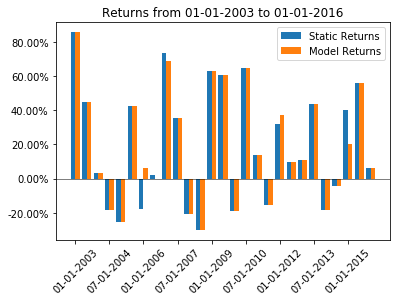

In [0]:
logCols = ['50 Day Moving Average Ratio', 
           'Volume',
           'Market / Book Ratio',
           'P/E',
           'Debt / Equity Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('AMZN', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 3556.72%   (30.55% /yr)
	Model Returns: 1357.20%   (21.95% /yr)

Based on these results, an investor would have been better off holding onto the stock for the entire period. 
The total accuracy of the model was 0.49%  (min 0.00%,  max 1.00%)


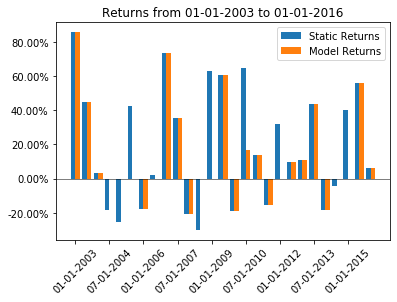

In [0]:
netCols = ['5 Day Change',
           '10 Day Moving Average Ratio',
           '50 Day Moving Average Ratio',
           '200 Day Moving Average Ratio',
           'Volume',
           'Market / Book Ratio',
           'P/E',
           'Debt / Equity Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('AMZN', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 1, daysIntoFuture = 130, printYears = 'some', numIter = 1000)

## Case Study: DuPont de Nemours, Inc. (DD)
Static Returns: 3.69% /yr

**Logistic Regrssion Returns: 5.66% /yr**

**Neural Network Returns: 7.93% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 63.20%   (3.69% /yr)
	Model Returns: 110.36%   (5.66% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.45%  (min 0.02%,  max 1.00%)


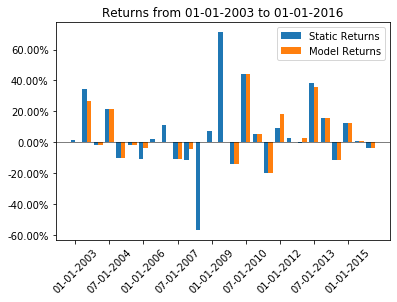

In [0]:
logCols = ['Free Cash Flow Yield',
           'Debt / Equity Ratio',
           'Market / Book Ratio',
           'P/E']
           
results = runAllPeriods('DD', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, trainDataYears = 1, daysIntoFuture = 65, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 63.20%   (3.69% /yr)
	Model Returns: 180.34%   (7.93% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.51%  (min 0.18%,  max 0.86%)


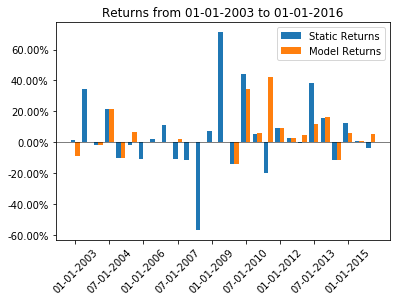

In [0]:
logCols = ['Free Cash Flow Yield',
           'Debt / Equity Ratio',
           'Market / Book Ratio',
           'P/E']
           
results = runAllPeriods('DD' , startMidDate, finalMidDate, modelType = 'NeuralNet', cols = logCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

## Case Study: Exxon Mobil Corporation (XOM)

Static Returns: 7.46% /yr

**Logistic Regression Returns: 11.74% /yr**

**Neural Network Returns: 13.47% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 164.28%   (7.46% /yr)
	Model Returns: 347.67%   (11.74% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.56%  (min 0.09%, median 0.62,  max 0.85%)


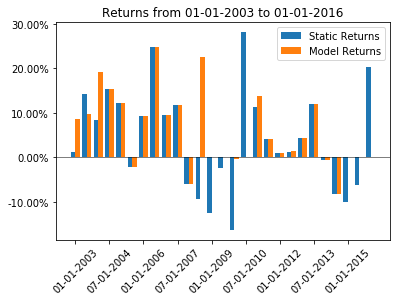

In [0]:
logCols = ['Debt / Equity Ratio',
           '50 Day Moving Average Ratio',
           '30 Day Change',
           '10 Day Moving Average Ratio',
           '5 Day Change',
           'Market / Book Ratio',
           '200 Day Moving Average Ratio']
           
results = runAllPeriods('XOM', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 164.28%   (7.46% /yr)
	Model Returns: 450.48%   (13.47% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.55%  (min 0.14%, median 0.61,  max 0.91%)


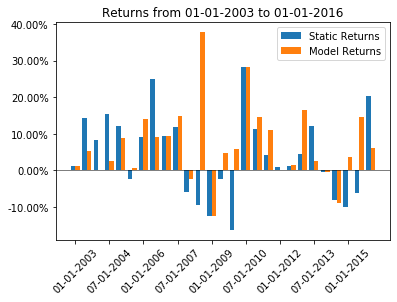

In [0]:
netCols = ['Debt / Equity Ratio',
           '50 Day Moving Average Ratio',
           '30 Day Change',
           '10 Day Moving Average Ratio',
           '5 Day Change',
           'Market / Book Ratio']
           
results = runAllPeriods('XOM', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 2, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

## Case Study: IBM Corporation (IBM)

Static Returns: 4.80% /yr

**Logistic Regression Returns: 7.66% /yr**

**Neural Network Returns: 8.31% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 88.38%   (4.80% /yr)
	Model Returns: 170.95%   (7.66% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.62%  (min 0.07%, median 0.67,  max 1.00%)


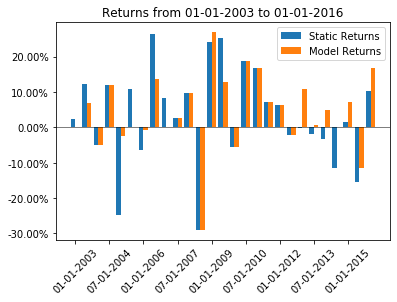

In [0]:
logCols = ['Free Cash Flow Yield',
           'P/E',
           'Price / 52 Week High',
           'Volume',
           'Market / Book Ratio']
           
results = runAllPeriods('IBM', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, trainDataYears = 1, daysIntoFuture = 65, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 88.38%   (4.80% /yr)
	Model Returns: 193.91%   (8.31% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.57%  (min 0.02%, median 0.63,  max 1.00%)


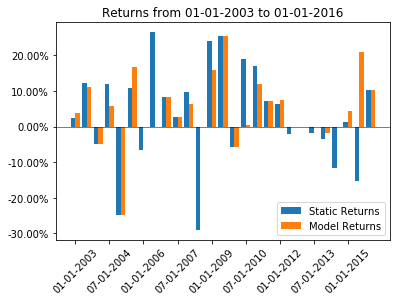

In [0]:
netCols = ['Free Cash Flow Yield',
           'P/E',
           'Price / 52 Week High',
           'Volume',
           'Market / Book Ratio']
           
results = runAllPeriods('IBM', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

## Case Study: Johnson & Johnson (JNJ)

Static Returns: 5.99% /yr

Logistic Regrssion Returns: 3.70% /yr

**Neural Network Returns: 7.25% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 119.23%   (5.99% /yr)
	Model Returns: 63.39%   (3.70% /yr)

Based on these results, an investor would have been better off holding onto the stock for the entire period. 
The total accuracy of the model was 0.50%  (min 0.05%,  max 0.90%)


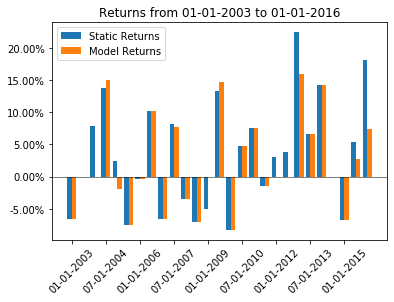

In [0]:
logCols = ['50 Day Moving Average Ratio', 
           'Volume',
           'Market / Book Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('JNJ', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 119.23%   (5.99% /yr)
	Model Returns: 157.17%   (7.25% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.43%  (min 0.00%,  max 1.00%)


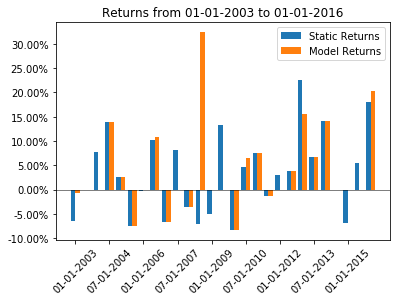

In [0]:
netCols = ['50 Day Moving Average Ratio',
           'Volume',
           'Market / Book Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('JNJ', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 2, daysIntoFuture = 130, printYears = 'some', numIter = 1000)

## Case Study: J.P. Morgan Chase & Co. (JPM)
Static Returns: 6.84% /yr

Logistic Regrssion Returns: 1.95% /yr

**Neural Network Returns: 8.92% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 144.26%   (6.84% /yr)
	Model Returns: 29.86%   (1.95% /yr)

Based on these results, an investor would have been better off holding onto the stock for the entire period. 
The total accuracy of the model was 0.50%  (min 0.17%,  max 0.88%)


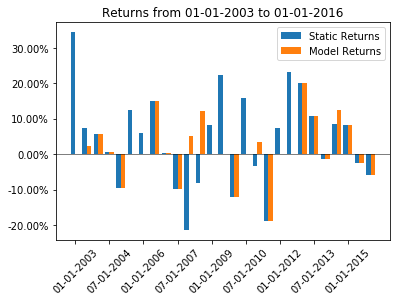

In [0]:
logCols = ['Price / 52 Week High',
           'Price / 52 Week Low',
           'P/E',
           'Market / Book Ratio',
           '200 Day Moving Average Ratio',
           '50 Day Moving Average Ratio',
            '1 Day Change']
           
results = runAllPeriods('JPM' , startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 144.26%   (6.84% /yr)
	Model Returns: 216.81%   (8.92% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.50%  (min 0.00%,  max 1.00%)


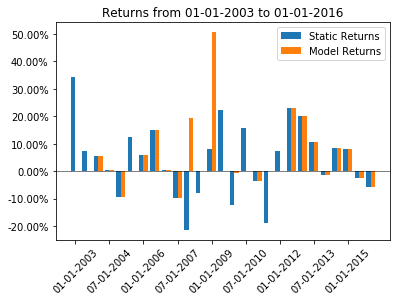

In [0]:
netCols = ['Price / 52 Week High',
           'P/E',
           'Market / Book Ratio',
           '200 Day Moving Average Ratio']
           
results = runAllPeriods('JPM' , startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 2, daysIntoFuture = 130, printYears = 'some', numIter = 1000)

## Case Study: Microsoft Coporation (MSFT)

Static Returns: 4.89% /yr

**Logistic Regression Returns: 7.79% /yr**

**Neural Network Returns: 6.55% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 90.51%   (4.89% /yr)
	Model Returns: 175.13%   (7.79% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.51%  (min 0.08%, median 0.54,  max 0.97%)


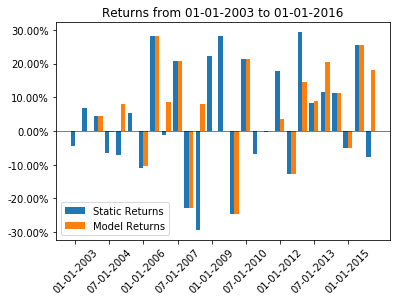

In [0]:
logCols = ['Market / Book Ratio',
           'Price / 52 Week High',
           '200 Day Moving Average Ratio',
           'Volume']
           
results = runAllPeriods('MSFT', startMidDate, finalMidDate, modelType = 'LogReg', cols = logCols, trainDataYears = 1, daysIntoFuture = 65, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 90.51%   (4.89% /yr)
	Model Returns: 135.58%   (6.55% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.51%  (min 0.16%, median 0.51,  max 0.88%)


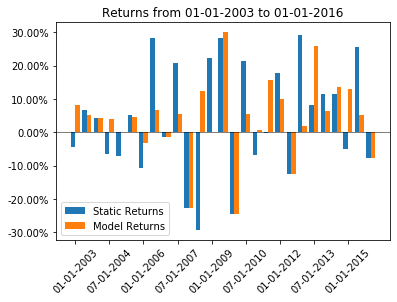

In [0]:
netCols = ['Market / Book Ratio',
           'Price / 52 Week High',
           '200 Day Moving Average Ratio',
           '30 Day Change']
           
results = runAllPeriods('MSFT', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

## Case Study: Walt Disney Co (DIS)

Static Returns: 13.83% /yr

Logistic Regrssion Returns: 13.68% /yr

**Neural Network Returns: 16.11% /yr**

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 474.50%   (13.83% /yr)
	Model Returns: 464.91%   (13.68% /yr)

Based on these results, an investor would have been better off holding onto the stock for the entire period. 
The total accuracy of the model was 0.56%  (min 0.06%, median 0.55,  max 0.93%)


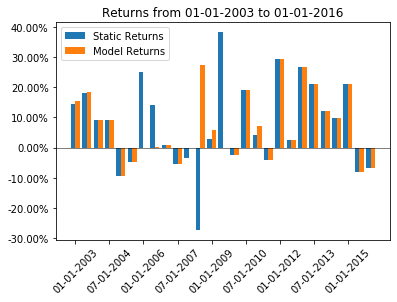

In [0]:
netCols = ['5 Day Change',
           '10 Day Moving Average Ratio',
           '50 Day Moving Average Ratio',
           '200 Day Moving Average Ratio',
           'Volume',
           'Market / Book Ratio',
           'P/E',
           'Debt / Equity Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('DIS', startMidDate, finalMidDate, modelType = 'LogReg', cols = netCols, trainDataYears = 1, daysIntoFuture = 30, printYears = 'some', numIter = 1000)

Testing period from Jan 01, 2003 to Jul 01, 2003
Testing period from Jan 01, 2005 to Jul 01, 2005
Testing period from Jan 01, 2007 to Jul 01, 2007
Testing period from Jan 01, 2009 to Jul 01, 2009
Testing period from Jan 01, 2011 to Jul 01, 2011
Testing period from Jan 01, 2013 to Jul 01, 2013
Testing period from Jan 01, 2015 to Jul 01, 2015

From the period 01-01-2003 to 07-01-2016, the total returns were:
	Static Returns: 474.50%   (13.83% /yr)
	Model Returns: 651.33%   (16.11% /yr)

Based on these results, an investor would have been better off using the model to buy/sell the stock throughout the period. 
The total accuracy of the model was 0.58%  (min 0.00%,  max 1.00%)


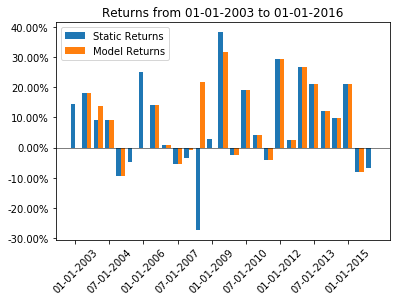

In [0]:
netCols = ['5 Day Change',
           '10 Day Moving Average Ratio',
           '50 Day Moving Average Ratio',
           '200 Day Moving Average Ratio',
           'Volume',
           'Market / Book Ratio',
           'P/E',
           'Debt / Equity Ratio',
           'Free Cash Flow Yield']
           
results = runAllPeriods('DIS', startMidDate, finalMidDate, modelType = 'NeuralNet', cols = netCols, trainDataYears = 1, daysIntoFuture = 130, printYears = 'some', numIter = 1000)

# Evaluation

Below are the annualized returns of each model for the tested companies:

|Stock                   |Static Return|Logistic Regression|Neural Network|
|-----------------------:|------------:|------------------:|-------------:|
|Amazon.com, Inc.        |30.55%       |**31.51%**         |21.95%        |
|DuPont de Nemours, Inc. |3.69%        |**5.66%**          |**7.93%**     |
|Exxon Mobil Corporation |7.46%        |**11.74%**         |**13.47%**    |
|IBM Corporation         |4.80%        |**7.66%**          |**8.31%**     |
|Johnson & Johnson       |5.90%        |3.70%              |**7.25%**     |
|J.P. Morgan Chase & Co. |6.84%        |1.95%              |**8.92%**     |
|Microsoft Corporation   |4.89%        |**7.79%**          |**6.55%**     |
|Walt Disney Co          |13.83%       |13.68%             |**16.11%**    |

*Bolded returns reflect annualized returns that were greater than the unengaged investor*


**Conclusions**

The above chart shows that the model was able to successfully outperform the unengaged investor for all 8 securities tested. Companies were chosen from a broad range of sectors to test the robustness of the model.

The logistic regression proved to be the more lucrative investing technique for 5/8 holdings, with an average return of 0.72% /yr greater than the static return.

The neural network proved to be the more lucrative investing technique for 7/8 holdings, with an average return of 1.57% /yr greater than the static return. Among the 7 stocks in which the model performed better, the average return was 3.02% /yr greater than the static return.

**Recommendations**

While the model appears to have performed well, I would not recommend using this to guide any investment decisions. The use of averaging over many years and multiple economic cycles is naiive, expecially considering the lack of information used in the decision making process of these models. This model can serve as a guide, but it should not be used to pick which securities to buy. **The purpose of this model is to maximize the returns of a holding, not to give input on which stocks will outperform others.**